This example requires the following dependencies to be installed:
pip install lightly

In [1]:
!pip install lightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.4 MB/s eta 0:00:00


Note: The model and training settings do not follow the reference settings
from the paper. The settings are chosen such that the example can easily be
run on a small dataset with a single GPU.

In [2]:
import torch
import torchvision
from torch import nn

In [3]:
from lightly.loss import NTXentLoss
from lightly.models.modules import SimCLRProjectionHead
from lightly.transforms.simclr_transform import SimCLRTransform

In [4]:
class SimCLR(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimCLRProjectionHead(512, 512, 128)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

In [26]:
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = SimCLR(backbone)

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

SimCLR(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [7]:
transform = SimCLRTransform(input_size=32, gaussian_blur=0.0)
dataset = torchvision.datasets.CIFAR10(
    "datasets/cifar10", download=True, transform=transform
)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder", transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


In [9]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    drop_last=True,
    num_workers=2,
)

In [28]:
criterion = NTXentLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

In [29]:
print("Starting Training")
for epoch in range(25):
    total_loss = 0
    for batch in dataloader:
        x0, x1 = batch[0]
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model(x0)
        z1 = model(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Starting Training
epoch: 00, loss: 5.87414
epoch: 01, loss: 5.67728
epoch: 02, loss: 5.60924
epoch: 03, loss: 5.55603
epoch: 04, loss: 5.52049
epoch: 05, loss: 5.48423
epoch: 06, loss: 5.46473
epoch: 07, loss: 5.44704
epoch: 08, loss: 5.42651
epoch: 09, loss: 5.40693
epoch: 10, loss: 5.39997
epoch: 11, loss: 5.38271
epoch: 12, loss: 5.37126
epoch: 13, loss: 5.36234
epoch: 14, loss: 5.35010
epoch: 15, loss: 5.34242
epoch: 16, loss: 5.33684
epoch: 17, loss: 5.33225
epoch: 18, loss: 5.32395
epoch: 19, loss: 5.31601
epoch: 20, loss: 5.31469
epoch: 21, loss: 5.30174
epoch: 22, loss: 5.29878
epoch: 23, loss: 5.29523
epoch: 24, loss: 5.29513


In [30]:
model.eval()
from torchvision import transforms

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

viz_dataset = torchvision.datasets.CIFAR10(
    "datasets/cifar10",
    train=False,
    download=True,
    transform=test_transform
)

viz_loader = torch.utils.data.DataLoader(
    viz_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=2
)


In [31]:
import numpy as np

embeddings = []
labels = []

with torch.no_grad():
    for x, y in viz_loader:
        x = x.to(device)
        z = model(x)              # [B, 128]
        embeddings.append(z.cpu())
        labels.append(y)

embeddings = torch.cat(embeddings).numpy()
labels = torch.cat(labels).numpy()


In [32]:
embeddings = []
labels = []

model.eval()

with torch.no_grad():
    for x, y in viz_loader:
        x = x.to(device)

        f = model.backbone(x)     # [B, 512, 1, 1]
        f = f.flatten(start_dim=1)  # [B, 512]

        embeddings.append(f.cpu())

        labels.append(y)


In [33]:
from sklearn.decomposition import PCA

embeddings = torch.cat(embeddings, dim=0)   # [10000, 512]
embeddings = embeddings.numpy()

print(type(embeddings))
print(len(embeddings))
print(type(embeddings[0]))
print(embeddings[0].shape)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)



<class 'numpy.ndarray'>
10000
<class 'numpy.ndarray'>
(512,)


In [34]:
labels = torch.cat(labels, dim=0)   # [10000]
labels = labels.numpy()

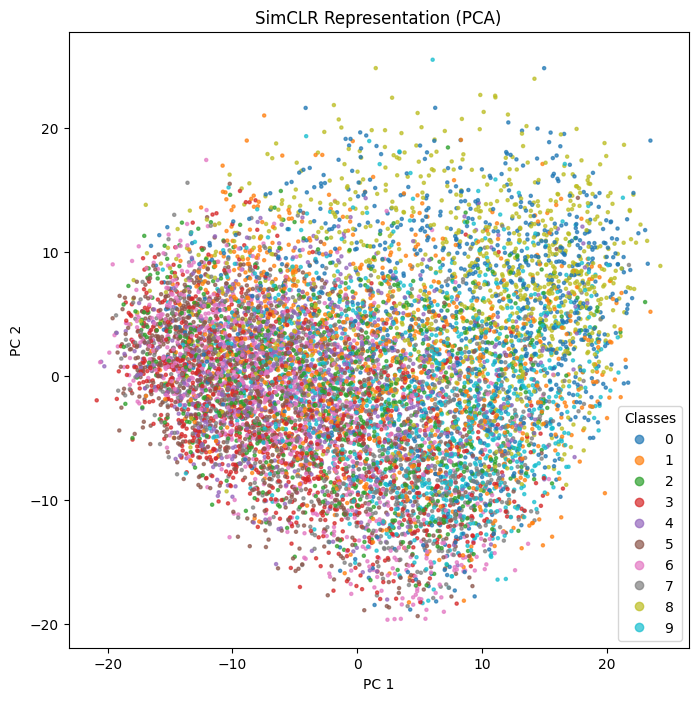

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=labels,
    cmap="tab10",
    s=5,
    alpha=0.7
)

plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("SimCLR Representation (PCA)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()
